(probabilistic_matrix_factorization)=
# Probabilistic Matrix Factorization for Making Personalized Recommendations

:::{post} June 3, 2022
:tags: case study, product recommendation, matrix factorization
:category: intermediate
:author: Ruslan Salakhutdinov, Andriy Mnih, Mack Sweeney, Colin Carroll, Rob Zinkov
:::

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 827
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Motivation

So you are browsing for something to watch on Netflix and just not liking the suggestions. You just know you can do better. All you need to do is collect some ratings data from yourself and friends and build a recommendation algorithm. This notebook will guide you in doing just that!

We'll start out by getting some intuition for how our model will work. Then we'll formalize our intuition. Afterwards, we'll examine the dataset we are going to use. Once we have some notion of what our data looks like, we'll define some baseline methods for predicting preferences for movies. Following that, we'll look at Probabilistic Matrix Factorization (PMF), which is a more sophisticated Bayesian method for predicting preferences. Having detailed the PMF model, we'll use PyMC for MAP estimation and MCMC inference. Finally, we'll compare the results obtained with PMF to those obtained from our baseline methods and discuss the outcome.

## Intuition

Normally if we want recommendations for something, we try to find people who are similar to us and ask their opinions. If Bob, Alice, and Monty are all similar to me, and they all like crime dramas, I'll probably like crime dramas. Now this isn't always true. It depends on what we consider to be "similar". In order to get the best bang for our buck, we really want to look for people who have the most similar taste. Taste being a complex beast, we'd probably like to break it down into something more understandable. We might try to characterize each movie in terms of various factors. Perhaps films can be moody, light-hearted, cinematic, dialogue-heavy, big-budget, etc. Now imagine we go through IMDb and assign each movie a rating in each of the categories. How moody is it? How much dialogue does it have? What's its budget? Perhaps we use numbers between 0 and 1 for each category. Intuitively, we might call this the film's profile.

Now let's suppose we go back to those 5 movies we rated. At this point, we can get a richer picture of our own preferences by looking at the film profiles of each of the movies we liked and didn't like. Perhaps we take the averages across the 5 film profiles and call this our ideal type of film. In other words, we have computed some notion of our inherent _preferences_ for various types of movies. Suppose Bob, Alice, and Monty all do the same. Now we can compare our preferences and determine how similar each of us really are. I might find that Bob is the most similar and the other two are still more similar than other people, but not as much as Bob. So I want recommendations from all three people, but when I make my final decision, I'm going to put more weight on Bob's recommendation than those I get from Alice and Monty.

While the above procedure sounds fairly effective as is, it also reveals an unexpected additional source of information. If we rated a particular movie highly, and we know its film profile, we can compare with the profiles of other movies. If we find one with very close numbers, it is probable we'll also enjoy this movie. Both this approach and the one above are commonly known as _neighborhood approaches_. Techniques that leverage both of these approaches simultaneously are often called _collaborative filtering_ {cite:p}`koren2009matrixfactorization`. The first approach we talked about uses user-user similarity, while the second uses item-item similarity. Ideally, we'd like to use both sources of information. The idea is we have a lot of items available to us, and we'd like to work together with others to filter the list of items down to those we'll each like best. My list should have the items I'll like best at the top and those I'll like least at the bottom. Everyone else wants the same. If I get together with a bunch of other people, we all watch 5 movies, and we have some efficient computational process to determine similarity, we can very quickly order the movies to our liking.

## Formalization

Let's take some time to make the intuitive notions we've been discussing more concrete. We have a set of $M$ movies, or _items_ ($M = 100$ in our example above). We also have $N$ people, whom we'll call _users_ of our recommender system. For each item, we'd like to find a $D$ dimensional factor composition (film profile above) to describe the item. Ideally, we'd like to do this without actually going through and manually labeling all of the movies. Manual labeling would be both slow and error-prone, as different people will likely label movies differently. So we model each movie as a $D$ dimensional vector, which is its latent factor composition. Furthermore, we expect each user to have some preferences, but without our manual labeling and averaging procedure, we have to rely on the latent factor compositions to learn $D$ dimensional latent preference vectors for each user. The only thing we get to observe is the $N \times M$ ratings matrix $R$ provided by the users. Entry $R_{ij}$ is the rating user $i$ gave to item $j$. Many of these entries may be missing, since most users will not have rated all 100 movies. Our goal is to fill in the missing values with predicted ratings based on the latent variables $U$ and $V$. We denote the predicted ratings by $R_{ij}^*$. We also define an indicator matrix $I$, with entry $I_{ij} = 0$ if $R_{ij}$ is missing and $I_{ij} = 1$ otherwise.

- $R$ is the user-item ratings matrix, with missing entries for unrated items.
- $U$ is the user latent factor matrix that encodes preferences across latent factors.
- $V$ is the item latent factor matrix that encodes each item's factor composition.
- $I$ is the indicator matrix for observed ratings.

So we have an $N \times D$ matrix of user preferences which we'll call $U$ and an $M \times D$ factor composition matrix we'll call $V$. We also have a $N \times M$ rating matrix we'll call $R$. We can think of each row $U_i$ as indications of how much each user prefers each of the $D$ latent factors. Each row $V_j$ can be thought of as how much each item can be described by each of the latent factors. In order to make a recommendation, we need a suitable prediction function which maps a user preference vector $U_i$ and an item latent factor vector $V_j$ to a predicted ranking. The choice of this prediction function is an important modeling decision, and a variety of prediction functions have been used. Perhaps the most common is the dot product of the two vectors, $U_i \cdot V_j$ {cite:p}`koren2009matrixfactorization`.

To better understand collaborative filtering techniques, let us explore a particular example. Imagine we are seeking to recommend movies using a model which infers five latent factors, $V_j$, for $j = 1,2,3,4,5$. In reality, the latent factors are often unexplainable in a straightforward manner, and most models make no attempt to understand what information is being captured by each factor.  However, for the purposes of explanation, let us assume the five latent factors might end up capturing the film profile we were discussing above. So our five latent factors are: moody, light-hearted, cinematic, dialogue, and budget. Then for a particular user $i$, imagine we infer a preference vector $U_i = <0.5, 0.1, 1.5, 1.1, 0.3>$. Also, for a particular item $j$, we infer these values for the latent factors: $V_j = <0.5, 1.5, 1.25, 0.8, 0.9>$. Using the dot product as the prediction function, we would calculate 3.425 as the ranking for that item, which is more or less a neutral preference given our 1 to 5 rating scale.

$$ 0.5 \times 0.5 + 0.1 \times 1.5 + 1.5 \times 1.25 + 1.1 \times 0.8 + 0.3 \times 0.9 = 3.425 $$

## Data

The MovieLens 100k dataset {cite:p}`harper2015movielens` was collected by the GroupLens Research Project at the University of Minnesota. This dataset consists of 100,000 ratings (1-5) from 943 users on 1682 movies. Each user rated at least 20 movies, and we have basic information on the users (age, gender, occupation, zip). Each movie includes basic information like title, release date, video release date, and genre. We will implement a model that is suitable for collaborative filtering on this data and evaluate it in terms of root mean squared error (RMSE) to validate the results.

The data was collected through the [MovieLens website](https://movielens.org/) during the seven-month period from September 19th,
1997 through April 22nd, 1998. This dataset has been cleaned up - users
who had less than 20 ratings or did not have complete demographic
information were removed from this dataset.


Let's begin by exploring our data. We want to get a general feel for what it looks like and a sense for what sort of patterns it might contain. Here are the user rating data:

In [3]:
data_kwargs = dict(sep="\t", names=["userid", "itemid", "rating", "timestamp"])
try:
    data = pd.read_csv("../data/ml_100k_u.data", **data_kwargs)
except FileNotFoundError:
    data = pd.read_csv(pm.get_data("ml_100k_u.data"), **data_kwargs)

data.head()

,userid,itemid,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


And here is the movie detail data:

In [4]:
# fmt: off
movie_columns  = ['movie id', 'movie title', 'release date', 'video release date', 'IMDb URL', 
                  'unknown','Action','Adventure', 'Animation',"Children's", 'Comedy', 'Crime',
                  'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                  'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
# fmt: on

item_kwargs = dict(sep="|", names=movie_columns, index_col="movie id", parse_dates=["release date"])
try:
    movies = pd.read_csv("../data/ml_100k_u.item", **item_kwargs)
except FileNotFoundError:
    movies = pd.read_csv(pm.get_data("ml_100k_u.item"), **item_kwargs)

movies.head()

,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


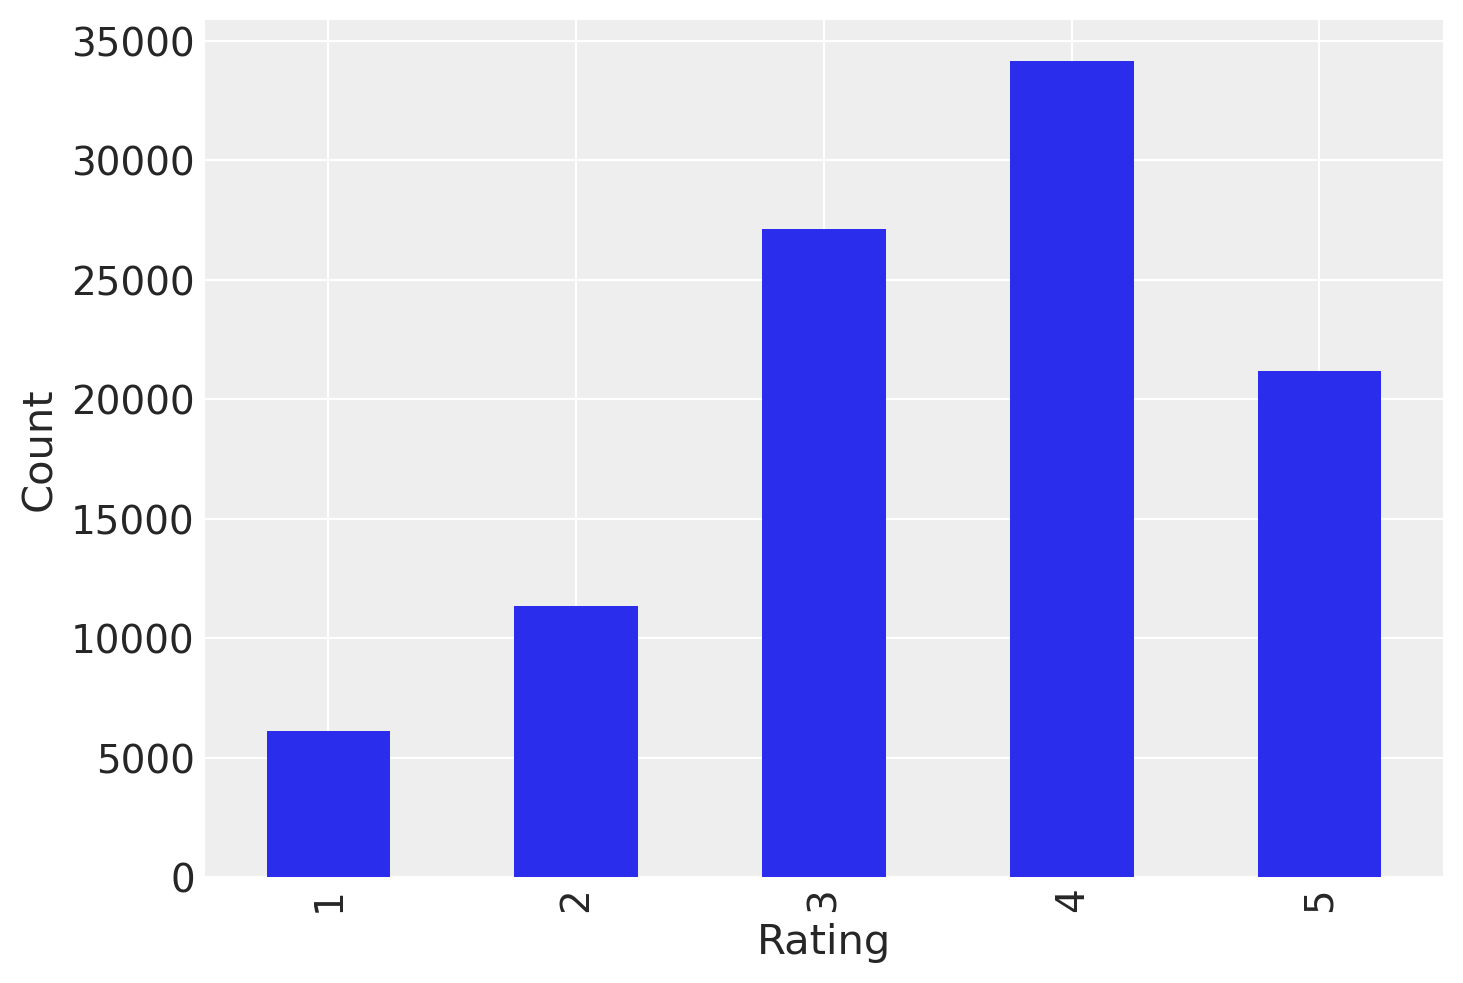

In [5]:
# Plot histogram of ratings
ax = data.groupby("rating").size().plot(kind="bar")
ax.set_xlabel("Rating")
ax.set_ylabel("Count");

In [6]:
data.rating.describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

This must be a decent batch of movies. From our exploration above, we know most ratings are in the range 3 to 5, and positive ratings are more likely than negative ratings. Let's look at the means for each movie to see if we have any particularly good (or bad) movie here.

/home/ckrapu/anaconda3/envs/pymc_env/lib/python3.14/site-packages/IPython/core/events.py:96: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  func(*args, **kwargs)
/home/ckrapu/anaconda3/envs/pymc_env/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


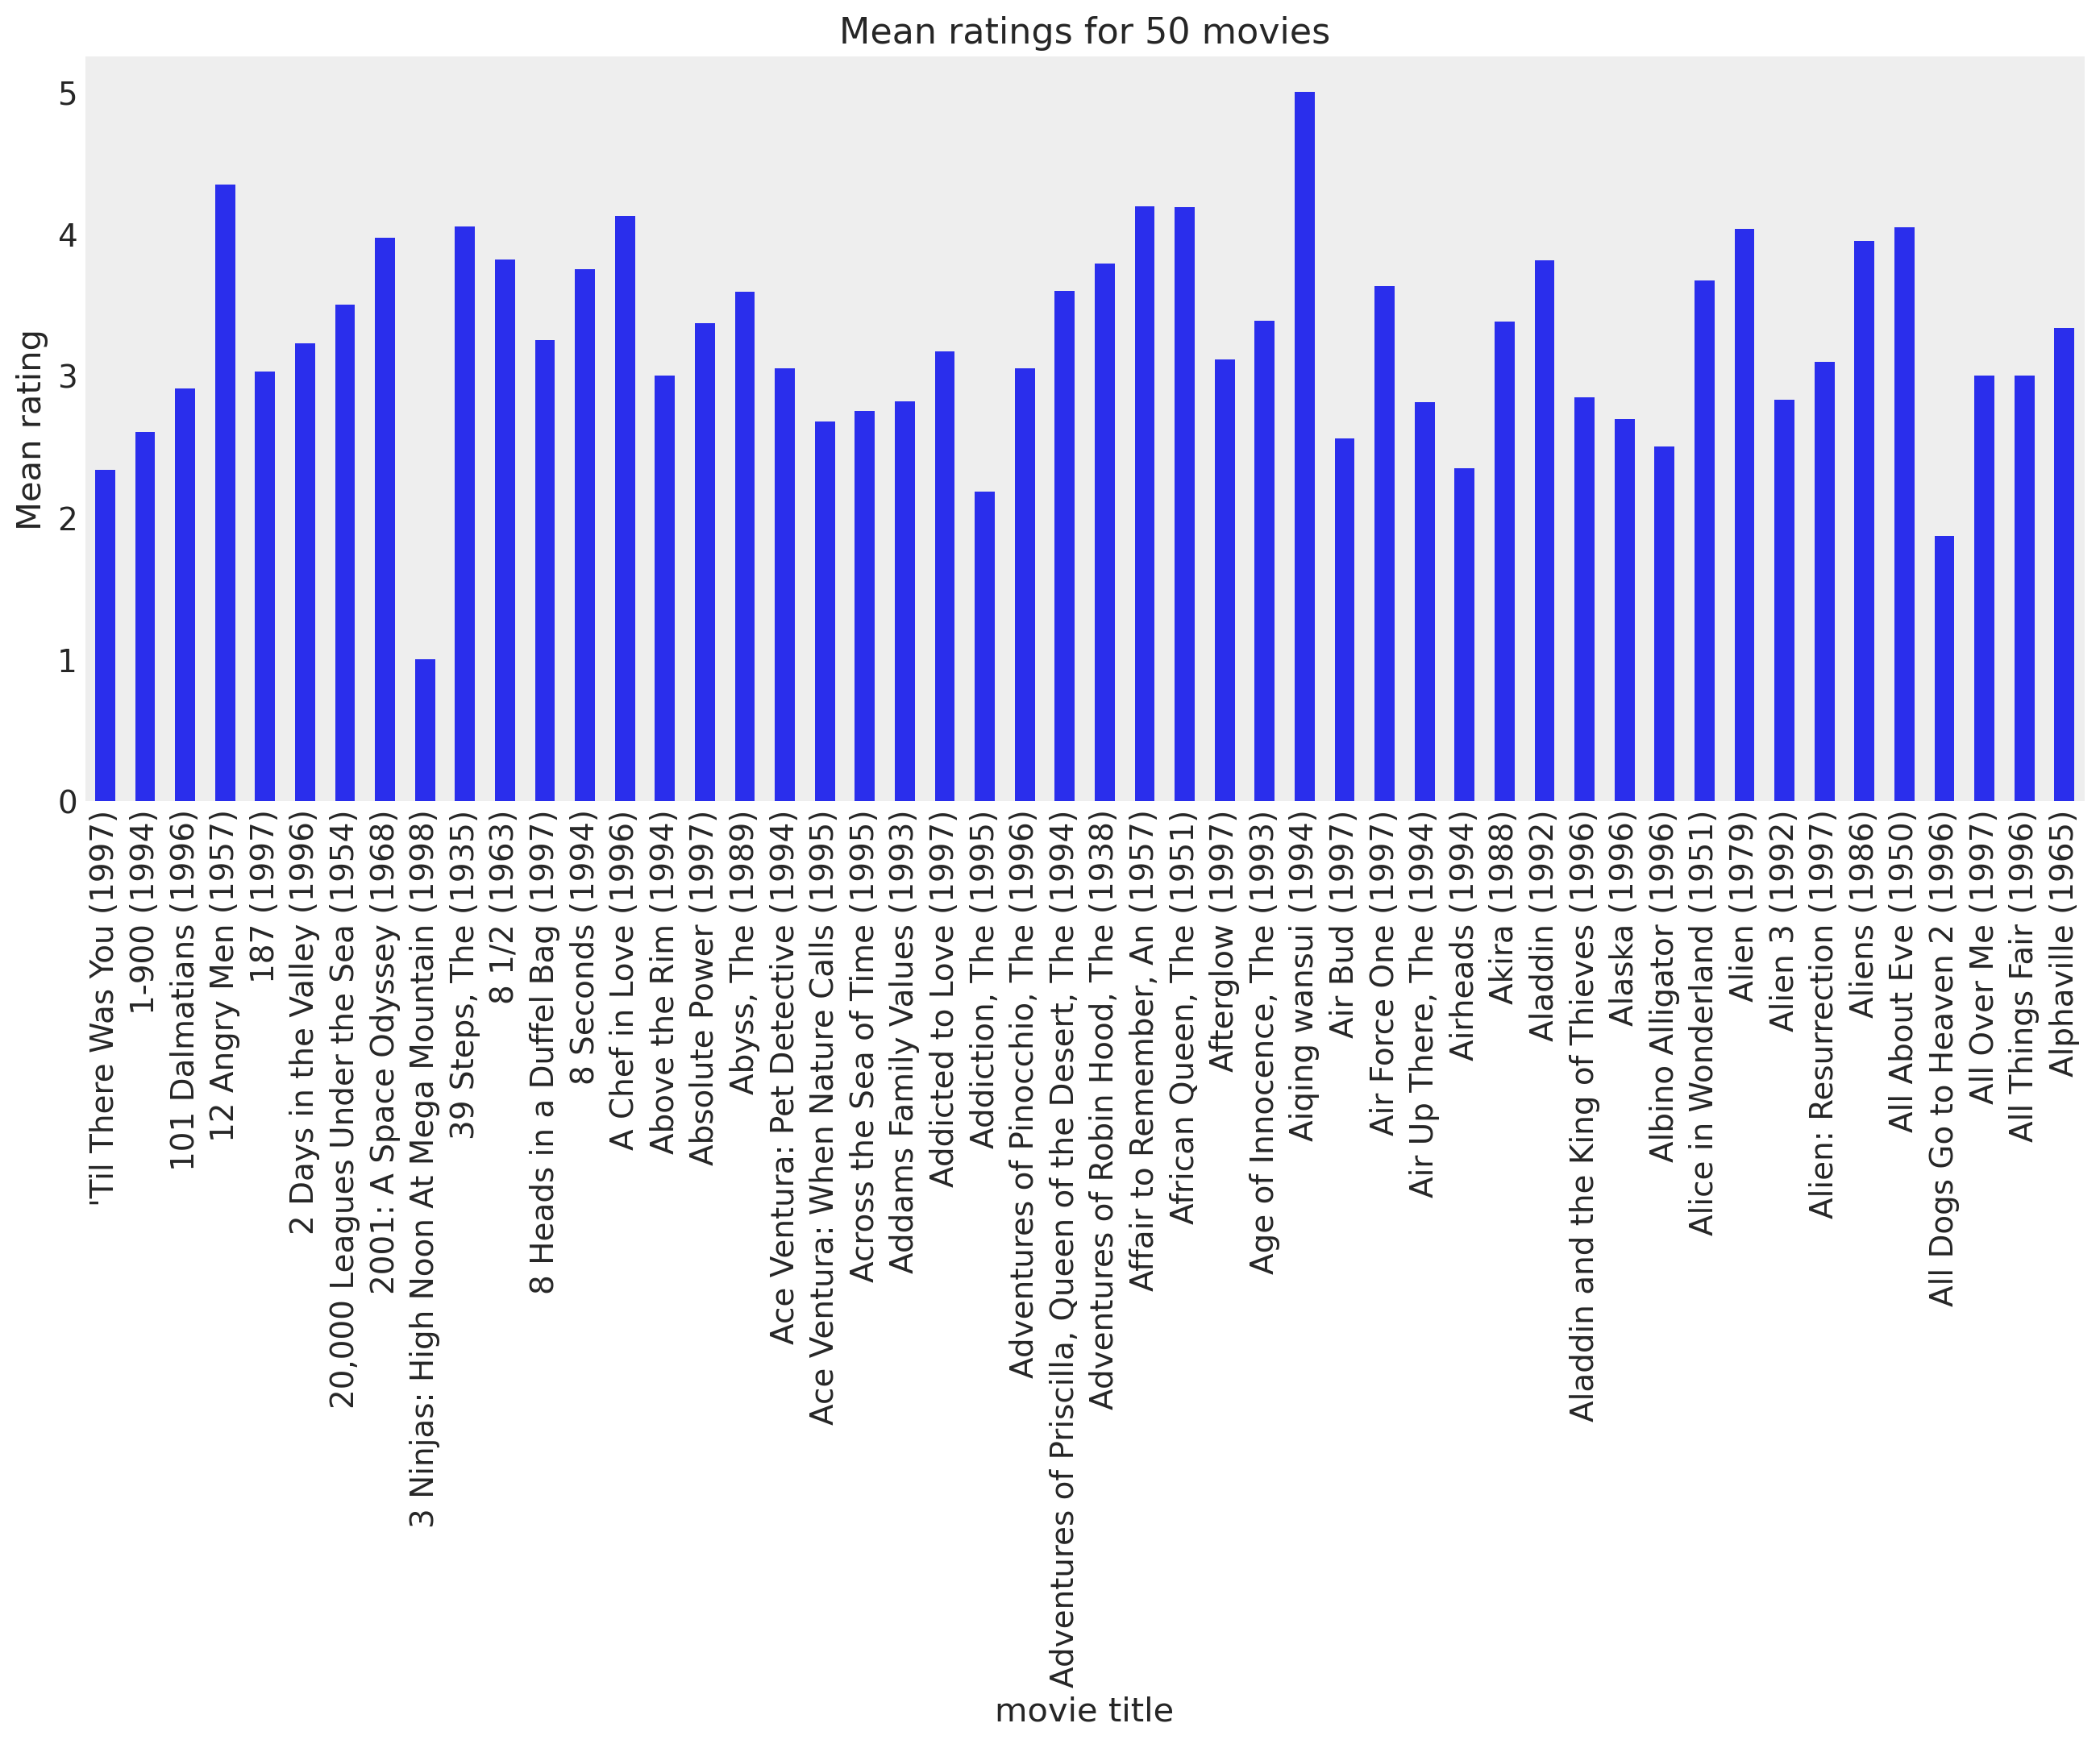

In [7]:
movie_means = data.join(movies["movie title"], on="itemid").groupby("movie title").rating.mean()
ax = movie_means[:50].plot(
    kind="bar", grid=False, figsize=(16, 6), title="Mean ratings for 50 movies"
)
ax.set_ylabel("Mean rating");

While the majority of the movies generally get positive feedback from users, there are definitely a few that stand out as bad. Let's take a look at the worst and best movies, just for fun:

/home/ckrapu/anaconda3/envs/pymc_env/lib/python3.14/site-packages/IPython/core/events.py:96: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  func(*args, **kwargs)
/home/ckrapu/anaconda3/envs/pymc_env/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


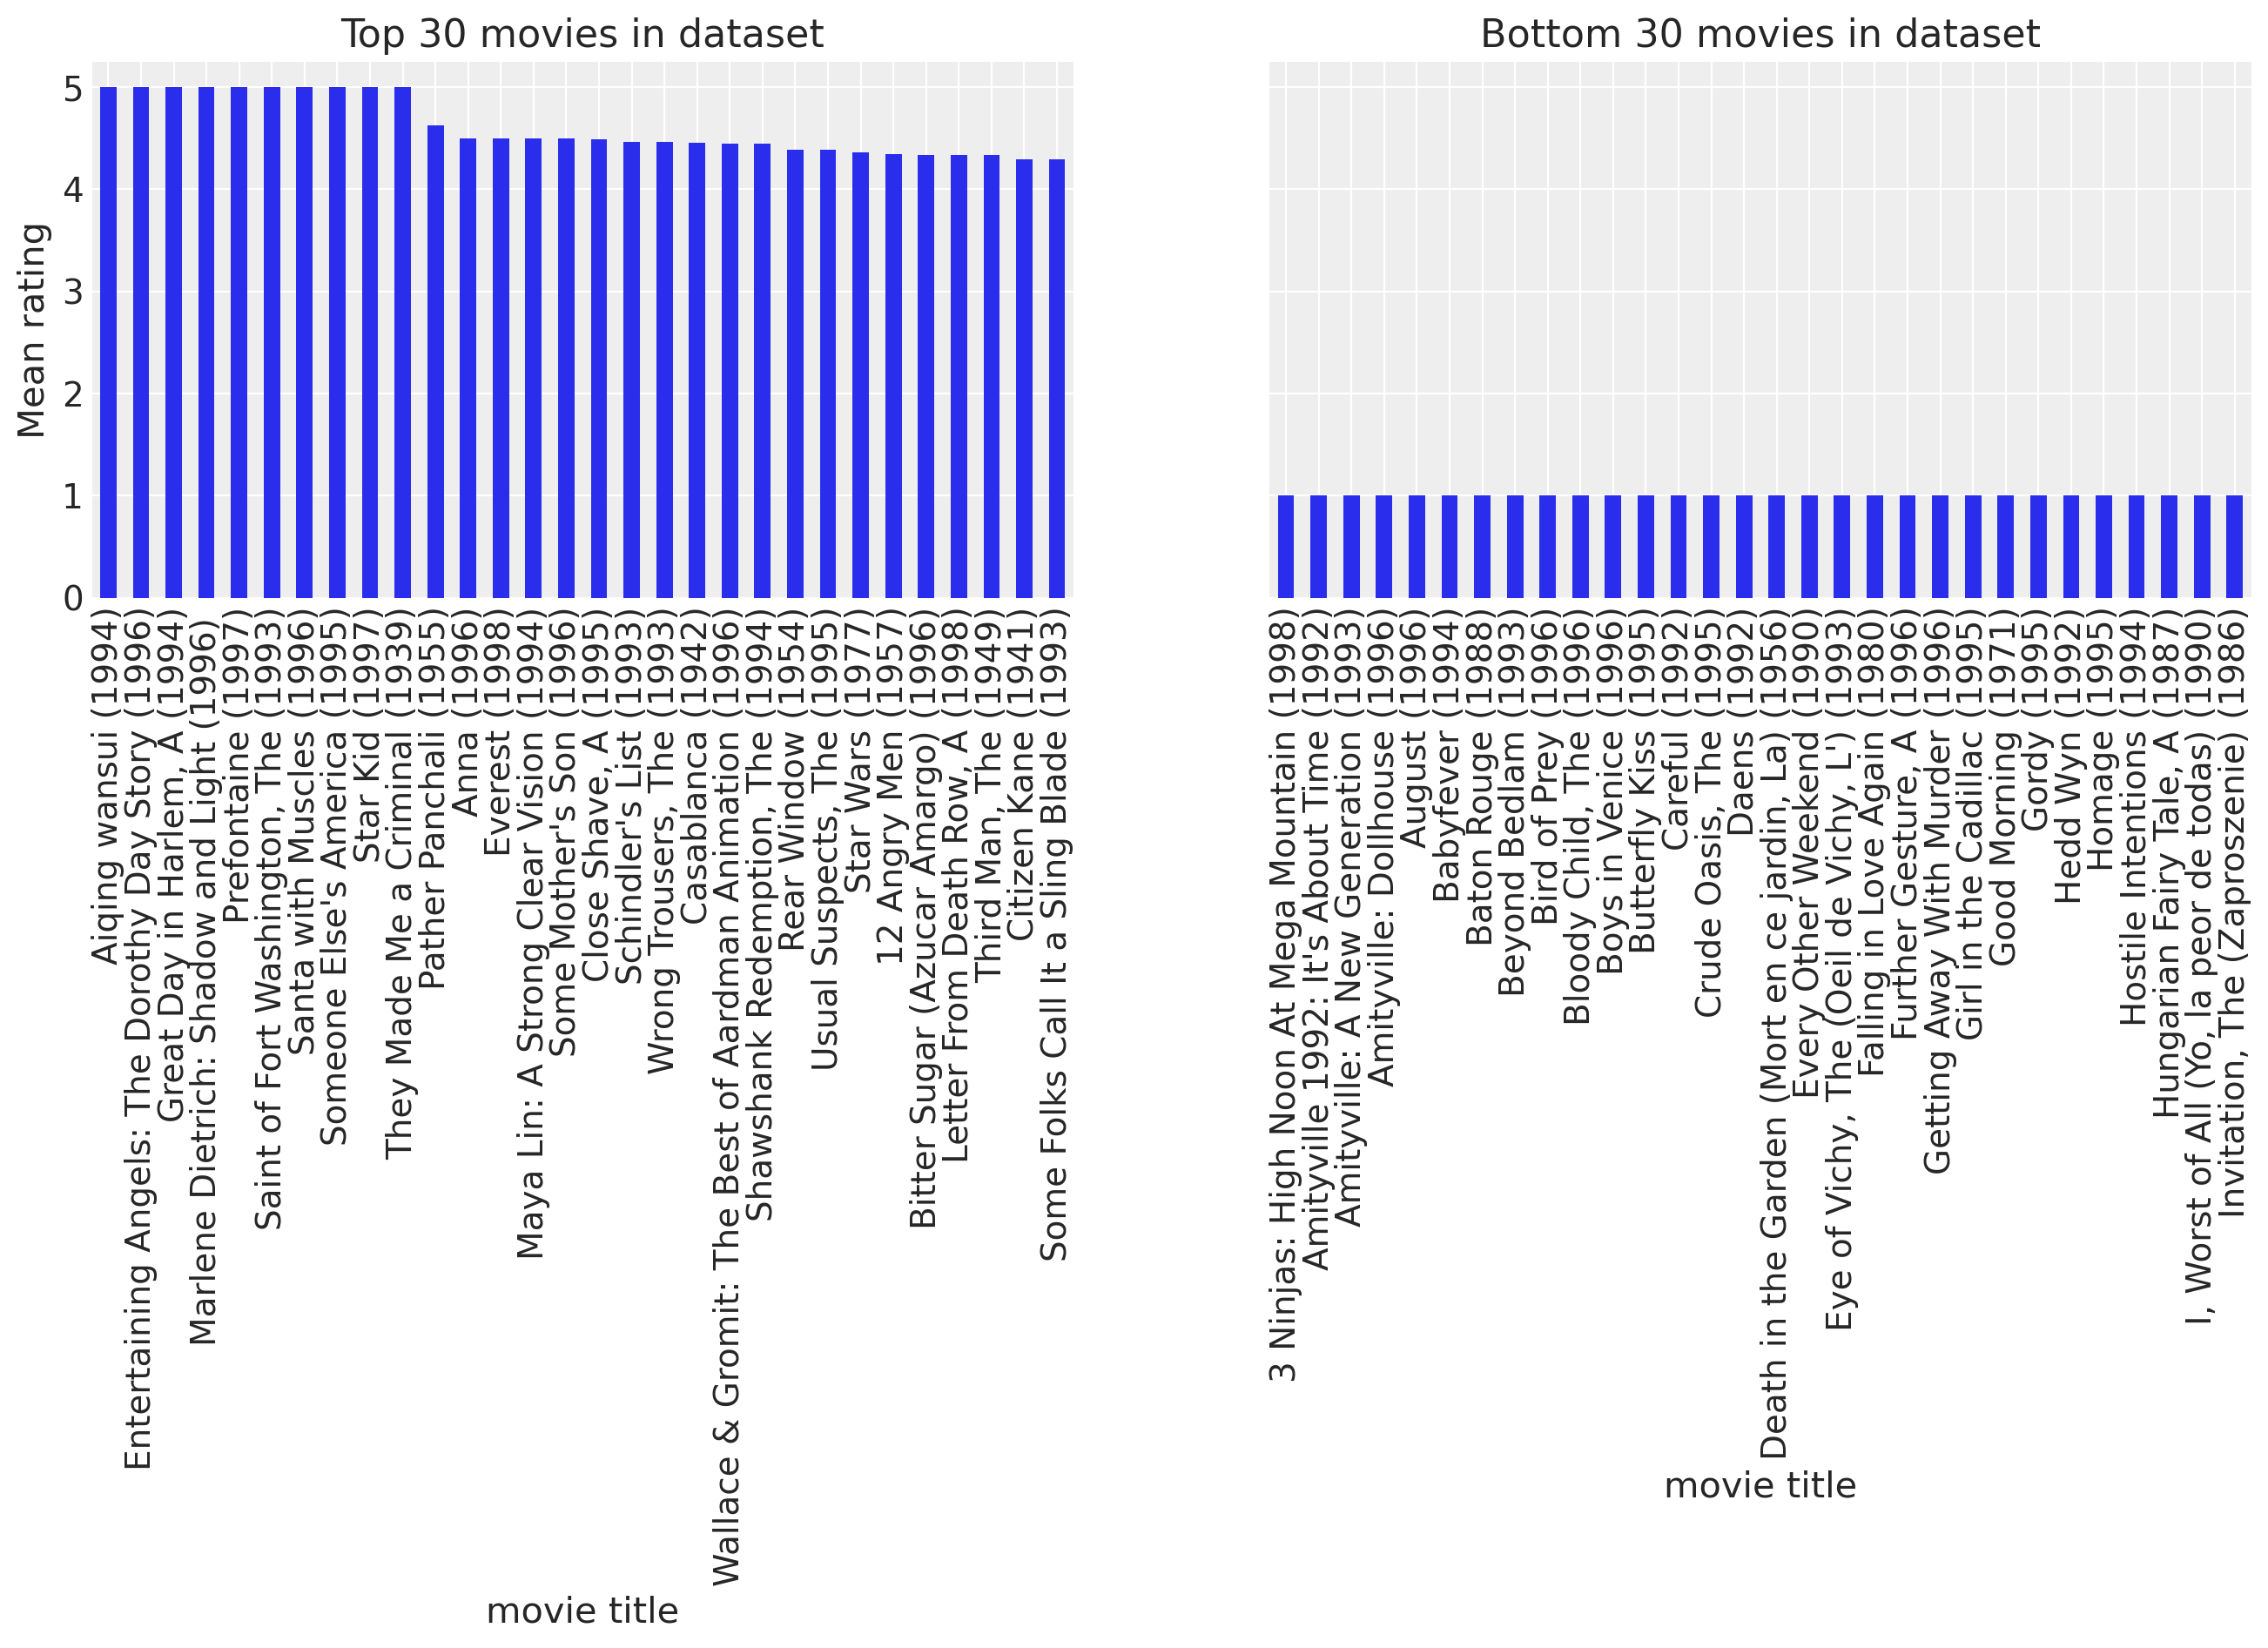

In [8]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 4), sharey=True)
movie_means.nlargest(30).plot(kind="bar", ax=ax1, title="Top 30 movies in dataset")
movie_means.nsmallest(30).plot(kind="bar", ax=ax2, title="Bottom 30 movies in dataset")
ax1.set_ylabel("Mean rating");

Makes sense to me. We now know there are definite popularity differences between the movies. Some of them are simply better than others, and some are downright lousy. Looking at the movie means allowed us to discover these general trends. Perhaps there are similar trends across users. It might be the case that some users are simply more easily entertained than others. Let's take a look.

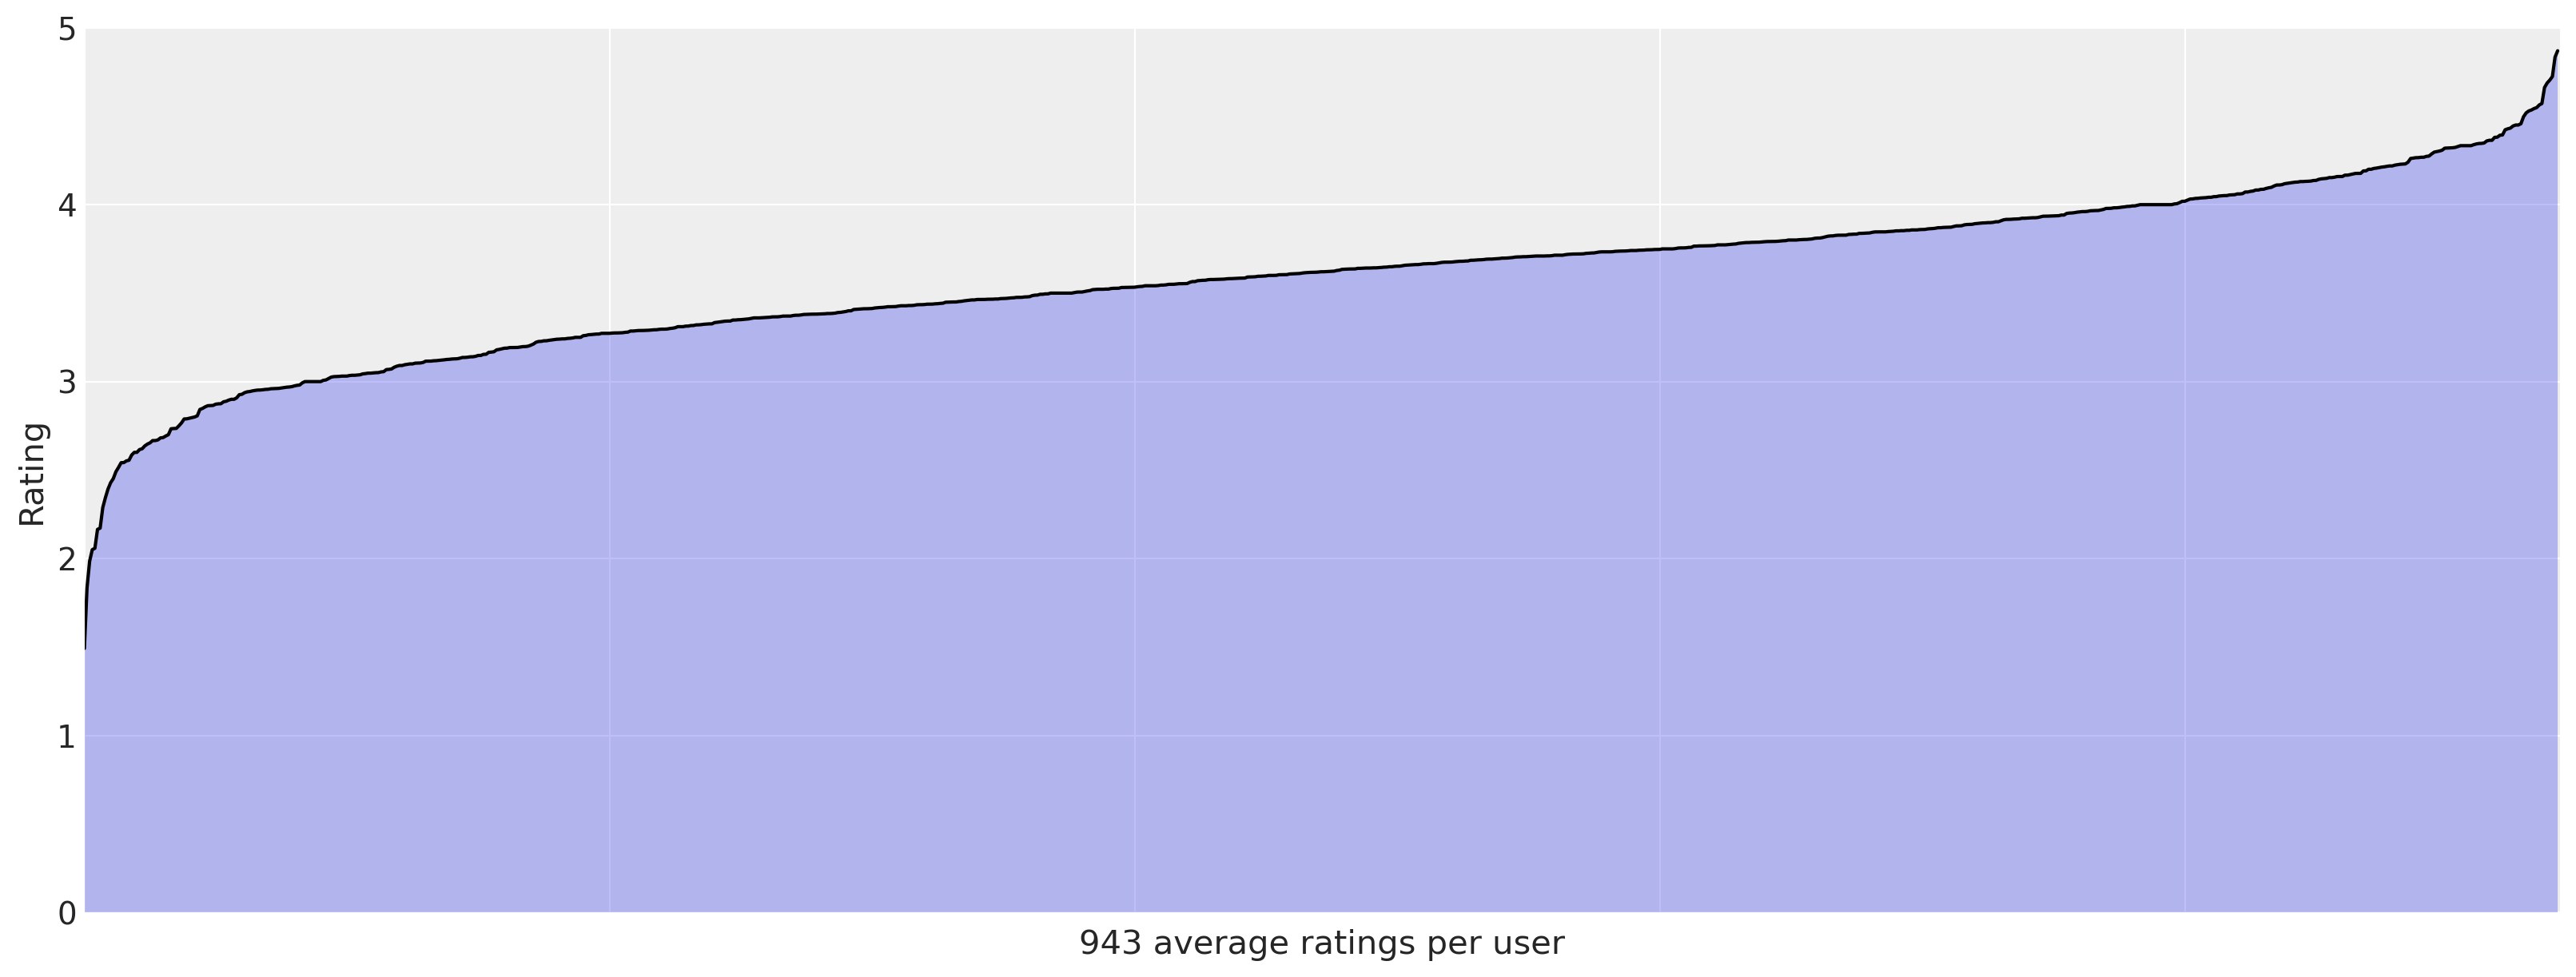

In [9]:
user_means = data.groupby("userid").rating.mean().sort_values()
_, ax = plt.subplots(figsize=(16, 6))
ax.plot(np.arange(len(user_means)), user_means.values, "k-")

ax.fill_between(np.arange(len(user_means)), user_means.values, alpha=0.3)
ax.set_xticklabels("")
# 1000 labels is nonsensical
ax.set_ylabel("Rating")
ax.set_xlabel(f"{len(user_means)} average ratings per user")
ax.set_ylim(0, 5)
ax.set_xlim(0, len(user_means));

We see even more significant trends here. Some users rate nearly everything highly, and some (though not as many) rate nearly everything negatively. These observations will come in handy when considering models to use for predicting user preferences on unseen movies.

## Methods

Having explored the data, we're now ready to dig in and start addressing the problem. We want to predict how much each user is going to like all of the movies they have not yet rated.


### Baselines

Every good analysis needs some kind of baseline methods to compare against. It's difficult to claim we've produced good results if we have no reference point for what defines "good". We'll define three very simple baseline methods and find the RMSE using these methods. Our goal will be to obtain lower RMSE scores with whatever model we produce.

#### Uniform Random Baseline

Our first baseline is about as dead stupid as you can get. Every place we see a missing value in $R$, we'll simply fill it with a number drawn uniformly at random in the range [1, 5]. We expect this method to do the worst by far.

$$R_{ij}^* \sim Uniform(1,5)$$

#### Global Mean Baseline

This method is only slightly better than the last. Wherever we have a missing value, we'll fill it in with the mean of all observed ratings.

$$\text{global_mean} = \frac{1}{N \times M} \sum_{i=1}^N \sum_{j=1}^M I_{ij}(R_{ij})$$

$$R_{ij}^* = \text{global_mean}$$

#### Mean of Means Baseline

Now we're going to start getting a bit smarter. We imagine some users might be easily amused, and inclined to rate all movies more highly. Other users might be the opposite. Additionally, some movies might simply be more witty than others, so all users might rate some movies more highly than others in general. We can clearly see this in our graph of the movie means above. We'll attempt to capture these general trends through per-user and per-movie rating means. We'll also incorporate the global mean to smooth things out a bit. So if we see a missing value in cell $R_{ij}$, we'll average the global mean with the mean of $U_i$ and the mean of $V_j$ and use that value to fill it in.

$$\text{user_means} = \frac{1}{M} \sum_{j=1}^M I_{ij}(R_{ij})$$

$$\text{movie_means} = \frac{1}{N} \sum_{i=1}^N I_{ij}(R_{ij})$$

$$R_{ij}^* = \frac{1}{3} \left(\text{user_means}_i + \text{ movie_means}_j + \text{ global_mean} \right)$$

In [10]:
# Create a base class with scaffolding for our 3 baselines.


def split_title(title):
    """Change "BaselineMethod" to "Baseline Method"."""
    words = []
    tmp = [title[0]]
    for c in title[1:]:
        if c.isupper():
            words.append("".join(tmp))
            tmp = [c]
        else:
            tmp.append(c)
    words.append("".join(tmp))
    return " ".join(words)


class Baseline:
    """Calculate baseline predictions."""

    def __init__(self, train_data):
        """Simple heuristic-based transductive learning to fill in missing
        values in data matrix."""
        self.predict(train_data.copy())

    def predict(self, train_data):
        raise NotImplementedError("baseline prediction not implemented for base class")

    def rmse(self, test_data):
        """Calculate root mean squared error for predictions on test data."""
        return rmse(test_data, self.predicted)

    def __str__(self):
        return split_title(self.__class__.__name__)


# Implement the 3 baselines.


class UniformRandomBaseline(Baseline):
    """Fill missing values with uniform random values."""

    def predict(self, train_data):
        nan_mask = np.isnan(train_data)
        masked_train = np.ma.masked_array(train_data, nan_mask)
        pmin, pmax = masked_train.min(), masked_train.max()
        N = nan_mask.sum()
        train_data[nan_mask] = rng.uniform(pmin, pmax, N)
        self.predicted = train_data


class GlobalMeanBaseline(Baseline):
    """Fill in missing values using the global mean."""

    def predict(self, train_data):
        nan_mask = np.isnan(train_data)
        train_data[nan_mask] = train_data[~nan_mask].mean()
        self.predicted = train_data


class MeanOfMeansBaseline(Baseline):
    """Fill in missing values using mean of user/item/global means."""

    def predict(self, train_data):
        nan_mask = np.isnan(train_data)
        masked_train = np.ma.masked_array(train_data, nan_mask)
        global_mean = masked_train.mean()
        user_means = masked_train.mean(axis=1)
        item_means = masked_train.mean(axis=0)
        self.predicted = train_data.copy()
        n, m = train_data.shape
        for i in range(n):
            for j in range(m):
                if np.ma.isMA(item_means[j]):
                    self.predicted[i, j] = np.mean((global_mean, user_means[i]))
                else:
                    self.predicted[i, j] = np.mean((global_mean, user_means[i], item_means[j]))


baseline_methods = {}
baseline_methods["ur"] = UniformRandomBaseline
baseline_methods["gm"] = GlobalMeanBaseline
baseline_methods["mom"] = MeanOfMeansBaseline

In [11]:
num_users = data.userid.unique().shape[0]
num_items = data.itemid.unique().shape[0]
sparsity = 1 - len(data) / (num_users * num_items)
print(f"Users: {num_users}\nMovies: {num_items}\nSparsity: {sparsity}")

rating_matrix = data.pivot(index="userid", columns="itemid", values="rating")
dense_data = rating_matrix.to_numpy()

Users: 943
Movies: 1682
Sparsity: 0.9369533063577546


## Probabilistic Matrix Factorization

Probabilistic Matrix Factorization {cite:p}`mnih2008advances` is a probabilistic approach to the collaborative filtering problem that takes a Bayesian perspective. The ratings $R$ are modeled as draws from a Gaussian distribution.  The mean for $R_{ij}$ is $U_i V_j^T$. The precision $\alpha$ is a fixed parameter that reflects the uncertainty of the estimations; the normal distribution is commonly reparameterized in terms of precision, which is the inverse of the variance. Complexity is controlled by placing zero-mean spherical Gaussian priors on $U$ and $V$. In other words, each row of $U$ is drawn from a multivariate Gaussian with mean $\mu = 0$ and precision that is some multiple of the identity matrix $I$. Those multiples are $\alpha_U$ for $U$ and $\alpha_V$ for $V$. So our model is defined by:

$\newcommand\given[1][]{\:#1\vert\:}$

$$
P(R \given U, V, \alpha^2) = 
    \prod_{i=1}^N \prod_{j=1}^M
        \left[ \mathcal{N}(R_{ij} \given U_i V_j^T, \alpha^{-1}) \right]^{I_{ij}}
$$

$$
P(U \given \alpha_U^2) =
    \prod_{i=1}^N \mathcal{N}(U_i \given 0, \alpha_U^{-1} \boldsymbol{I})
$$

$$
P(V \given \alpha_U^2) =
    \prod_{j=1}^M \mathcal{N}(V_j \given 0, \alpha_V^{-1} \boldsymbol{I})
$$

Given small precision parameters, the priors on $U$ and $V$ ensure our latent variables do not grow too far from 0. This prevents overly strong user preferences and item factor compositions from being learned. This is commonly known as complexity control, where the complexity of the model here is measured by the magnitude of the latent variables. Controlling complexity like this helps prevent overfitting, which allows the model to generalize better for unseen data. We must also choose an appropriate $\alpha$ value for the normal distribution for $R$. So the challenge becomes choosing appropriate values for $\alpha_U$, $\alpha_V$, and $\alpha$. This challenge can be tackled with the soft weight-sharing methods discussed by {cite:t}`nowlan1992simplifying`. However, for the purposes of this analysis, we will stick to using point estimates obtained from our data.

In [12]:
import logging
import time

logging.basicConfig(level=logging.INFO)


class PMF:
    """Probabilistic Matrix Factorization model using PyMC."""

    def __init__(self, train, dim, alpha=2, std=0.01, bounds=(1, 5)):
        """Build the Probabilistic Matrix Factorization model using PyMC.

        :param np.ndarray train: The training data to use for learning the model.
        :param int dim: Dimensionality of the model; number of latent factors.
        :param int alpha: Fixed precision for the likelihood function.
        :param float std: Amount of noise to use for model initialization.
        :param (tuple of int) bounds: (lower, upper) bound of ratings.
            These bounds will simply be used to cap the estimates produced for R.
        """
        self.name = "PMF"
        self.dim = dim
        self.alpha = alpha
        self.std = np.sqrt(1.0 / alpha)
        self.bounds = bounds
        self.data = train.copy()
        n, m = self.data.shape

        # Perform mean value imputation
        nan_mask = np.isnan(self.data)
        self.data[nan_mask] = self.data[~nan_mask].mean()

        # Low precision reflects uncertainty; prevents overfitting.
        # Set to the mean variance across users and items.
        self.alpha_u = 1 / self.data.var(axis=1).mean()
        self.alpha_v = 1 / self.data.var(axis=0).mean()

        obs_user_idx, obs_movie_idx = np.where(~nan_mask)
        obs_user_idx = obs_user_idx.astype("int64")
        obs_movie_idx = obs_movie_idx.astype("int64")
        obs_ratings = self.data[~nan_mask]

        # Specify the model.
        logging.info("building the PMF model")
        with pm.Model(
            coords={
                "user": np.arange(n),
                "movie": np.arange(m),
                "latent_factor": np.arange(dim),
                "obs_id": np.arange(obs_ratings.shape[0]),
            }
        ) as pmf:
            user_idx_ = pm.Data("user_idx", obs_user_idx, dims="obs_id")
            movie_idx_ = pm.Data("movie_idx", obs_movie_idx, dims="obs_id")
            ratings_ = pm.Data("ratings", obs_ratings, dims="obs_id")

            U = pm.Normal(
                "U",
                mu=0,
                sigma=1 / np.sqrt(self.alpha_u),
                dims=("user", "latent_factor"),
                initval=rng.standard_normal(size=(n, dim)) * std,
            )
            V = pm.Normal(
                "V",
                mu=0,
                sigma=1 / np.sqrt(self.alpha_v),
                dims=("movie", "latent_factor"),
                initval=rng.standard_normal(size=(m, dim)) * std,
            )
            mu = (U[user_idx_] * V[movie_idx_]).sum(axis=-1)
            pm.Normal(
                "R",
                mu=mu,
                sigma=self.std,
                dims="obs_id",
                observed=ratings_,
            )

        logging.info("done building the PMF model")
        self.model = pmf

    def __str__(self):
        return self.name

We'll also need functions for calculating the MAP and performing sampling on our PMF model. When the observation noise variance $\alpha$ and the prior variances $\alpha_U$ and $\alpha_V$ are all kept fixed, maximizing the log posterior is equivalent to minimizing the sum-of-squared-errors objective function with quadratic regularization terms.

$$ E = \frac{1}{2} \sum_{i=1}^N \sum_{j=1}^M I_{ij} (R_{ij} - U_i V_j^T)^2 + \frac{\lambda_U}{2} \sum_{i=1}^N \|U\|_{Fro}^2 + \frac{\lambda_V}{2} \sum_{j=1}^M \|V\|_{Fro}^2, $$

where $\lambda_U = \alpha_U / \alpha$, $\lambda_V = \alpha_V / \alpha$, and $\|\cdot\|_{Fro}^2$ denotes the Frobenius norm {cite:p}`mnih2008advances`. Minimizing this objective function gives a local minimum, which is essentially a maximum a posteriori (MAP) estimate. While it is possible to use a fast Stochastic Gradient Descent procedure to find this MAP, we'll be finding it using the utilities built into PyMC. In particular, we'll use `find_MAP` with L-BFGS-B optimization and cap the maximum evaluations so the run stays tractable for the full dataset. Having found this MAP estimate, we can use it as our starting point for MCMC sampling.

Since it is a reasonably complex model, we expect the MAP estimation to take some time. So let's save it after we've found it. Note that we define a function for finding the MAP below, assuming it will receive a namespace with some variables in it. Then we attach that function to the PMF class, where it will have such a namespace after initialization. The PMF class is defined in pieces this way so I can say a few things between each piece to make it clearer.

In [13]:
def _find_map(self):
    """Find mode of posterior using L-BFGS-B optimization."""
    tstart = time.time()
    with self.model:
        logging.info("finding PMF MAP using L-BFGS-B optimization...")
        self._map = pm.find_MAP(method="L-BFGS-B", maxeval=2000)

    elapsed = int(time.time() - tstart)
    logging.info("found PMF MAP in %d seconds" % elapsed)
    return self._map


def _map(self):
    try:
        return self._map
    except AttributeError:
        return self.find_map()


# Update our class with the new MAP infrastructure.
PMF.find_map = _find_map
PMF.map = property(_map)

So now our PMF class has a `map` `property` which will either be found using Powell optimization or loaded from a previous optimization. Once we have the MAP, we can use it as a starting point for our MCMC sampler. We'll need a sampling function in order to draw MCMC samples to approximate the posterior distribution of the PMF model.

In [14]:
# Draw MCMC samples.
def _draw_samples(self, **kwargs):
    with self.model:
        self.idata = pm.sample(**kwargs)
    return self.idata


# Update our class with the sampling infrastructure.
PMF.draw_samples = _draw_samples

We could define some kind of default trace property like we did for the MAP, but that would mean using possibly nonsensical values for `nsamples` and `cores`. Better to leave it as a non-optional call to `draw_samples`. Finally, we'll need a function to make predictions using our inferred values for $U$ and $V$. For user $i$ and movie $j$, a prediction is generated by drawing from $\mathcal{N}(U_i V_j^T, \alpha)$. To generate predictions from the sampler, we generate an $R$ matrix for each $U$ and $V$ sampled, then we combine these by averaging over the $K$ samples.

$$
P(R_{ij}^* \given R, \alpha, \alpha_U, \alpha_V) \approx
    \frac{1}{K} \sum_{k=1}^K \mathcal{N}(U_i V_j^T, \alpha)
$$

We'll want to inspect the individual $R$ matrices before averaging them for diagnostic purposes. So we'll write code for the averaging piece during evaluation. The function below simply draws an $R$ matrix given a $U$ and $V$ and the fixed $\alpha$ stored in the PMF object.

In [15]:
def _predict(self, U, V):
    """Estimate R from the given values of U and V."""
    R = np.dot(U, V.T)
    sample_R = rng.normal(R, self.std)
    # bound ratings
    low, high = self.bounds
    return np.clip(sample_R, low, high)


PMF.predict = _predict

One final thing to note: the dot products in this model are often constrained using a logistic function $g(x) = 1/(1 + exp(-x))$, that bounds the predictions to the range [0, 1]. To facilitate this bounding, the ratings are also mapped to the range [0, 1] using $t(x) = (x + min) / range$. The authors of PMF also introduced a constrained version which performs better on users with fewer ratings {cite:p}`salakhutdinov2008bayesian`. Both models are generally improvements upon the basic model presented here. However, in the interest of time and space, these will not be implemented here.

## Evaluation

### Metrics

In order to understand how effective our models are, we'll need to be able to evaluate them. We'll be evaluating in terms of root mean squared error (RMSE), which looks like this:

$$
RMSE = \sqrt{ \frac{ \sum_{i=1}^N \sum_{j=1}^M I_{ij} (R_{ij} - R_{ij}^*)^2 }
                   { \sum_{i=1}^N \sum_{j=1}^M I_{ij} } }
$$

In this case, the RMSE can be thought of as the standard deviation of our predictions from the actual user preferences.

In [16]:
# Define our evaluation function.
def rmse(test_data, predicted):
    """Calculate root mean squared error.
    Ignoring missing values in the test data.
    """
    I = ~np.isnan(test_data)  # indicator for missing values
    N = I.sum()  # number of non-missing values
    sqerror = abs(test_data - predicted) ** 2  # squared error array
    mse = sqerror[I].sum() / N  # mean squared error
    return np.sqrt(mse)  # RMSE

### Training Data vs. Test Data

The next thing we need to do is split our data into a training set and a test set. Matrix factorization techniques use [transductive learning](http://en.wikipedia.org/wiki/Transduction_%28machine_learning%29) rather than inductive learning. So we produce a test set by taking a random sample of the cells in the full $N \times M$ data matrix. The values selected as test samples are replaced with `nan` values in a copy of the original data matrix to produce the training set. Since we'll be producing random splits, let's also write out the train/test sets generated. This will allow us to replicate our results. We'd like to be able to identify which split is which, so we'll take a hash of the indices selected for testing and use that to save the data.

In [17]:
# Define a function for splitting train/test data.
def split_train_test(data, percent_test=0.1):
    """Split the data into train/test sets.
    :param int percent_test: Percentage of data to use for testing. Default 10.
    """
    n, m = data.shape  # # users, # movies
    N = n * m  # # cells in matrix

    # Prepare train/test ndarrays.
    train = data.copy()
    test = np.ones(data.shape) * np.nan

    # Draw random sample of training data to use for testing.
    tosample = np.where(~np.isnan(train))  # ignore nan values in data
    idx_pairs = list(zip(tosample[0], tosample[1]))  # tuples of row/col index pairs

    test_size = int(len(idx_pairs) * percent_test)  # use 10% of data as test set
    train_size = len(idx_pairs) - test_size  # and remainder for training

    indices = np.arange(len(idx_pairs))  # indices of index pairs
    sample = rng.choice(indices, replace=False, size=test_size)

    # Transfer random sample from train set to test set.
    for idx in sample:
        idx_pair = idx_pairs[idx]
        test[idx_pair] = train[idx_pair]  # transfer to test set
        train[idx_pair] = np.nan  # remove from train set

    # Verify everything worked properly
    assert train_size == N - np.isnan(train).sum()
    assert test_size == N - np.isnan(test).sum()

    # Return train set and test set
    return train, test


train, test = split_train_test(dense_data)

## Results

In [18]:
# Let's see the results:
baselines = {}
for name in baseline_methods:
    Method = baseline_methods[name]
    method = Method(train)
    baselines[name] = method.rmse(test)
    print(f"{method} RMSE:\t{baselines[name]:.5f}")

Uniform Random Baseline RMSE:	1.71243
Global Mean Baseline RMSE:	1.13478
Mean Of Means Baseline RMSE:	1.02234


As expected: the uniform random baseline is the worst by far, the global mean baseline is next best, and the mean of means method is our best baseline. Now let's see how PMF stacks up.

In [19]:
# We use a fixed precision for the likelihood.
# This reflects uncertainty in the dot product.
# We choose 2 in the footsteps of Salakhutdinov and Mnih.
ALPHA = 2

# The dimensionality D; the number of latent factors.
# We can adjust this higher to try to capture more subtle
# characteristics of each movie. However, the higher it is,
# the more expensive our inference procedures will be.
# Specifically, we have D(N + M) latent variables. For our
# Movielens dataset, this means we have D(2625), so for 5
# dimensions, we are sampling 13125 latent variables.
DIM = 10

pmf = PMF(train, DIM, ALPHA, std=0.05)

INFO:root:building the PMF model
INFO:root:done building the PMF model


### Predictions Using MAP

In [20]:
# Find MAP for PMF.
pmf.find_map();

INFO:root:finding PMF MAP using L-BFGS-B optimization...


Output()

INFO:root:found PMF MAP in 31 seconds


Excellent. The first thing we want to do is make sure the MAP estimate we obtained is reasonable. We can do this by computing RMSE on the predicted ratings obtained from the MAP values of $U$ and $V$. First we define a function for generating the predicted ratings $R$ from $U$ and $V$. We ensure the actual rating bounds are enforced by setting all values below 1 to 1 and all values above 5 to 5. Finally, we compute RMSE for both the training set and the test set. We expect the test RMSE to be higher. The difference between the two gives some idea of how much we have overfit. Some difference is always expected, but a very low RMSE on the training set with a high RMSE on the test set is a definite sign of overfitting.

In [21]:
def eval_map(pmf_model, train, test):
    U = pmf_model.map["U"]
    V = pmf_model.map["V"]
    # Make predictions and calculate RMSE on train & test sets.
    predictions = pmf_model.predict(U, V)
    train_rmse = rmse(train, predictions)
    test_rmse = rmse(test, predictions)
    overfit = test_rmse - train_rmse

    # Print report.
    print("PMF MAP training RMSE: %.5f" % train_rmse)
    print("PMF MAP testing RMSE:  %.5f" % test_rmse)
    print("Train/test difference: %.5f" % overfit)

    return test_rmse


# Add eval function to PMF class.
PMF.eval_map = eval_map

In [22]:
# Evaluate PMF MAP estimates.
pmf_map_rmse = pmf.eval_map(train, test)
pmf_improvement = baselines["mom"] - pmf_map_rmse
print("PMF MAP Improvement:   %.5f" % pmf_improvement)

PMF MAP training RMSE: 1.00998
PMF MAP testing RMSE:  1.14062
Train/test difference: 0.13064
PMF MAP Improvement:   -0.11828


We actually see a decrease in performance between the MAP estimate and the mean of means performance. We also have a fairly large difference in the RMSE values between the train and the test sets. This indicates that the point estimates for $\alpha_U$ and $\alpha_V$ that we calculated from our data are not doing a great job of controlling model complexity. 

Let's see if we can improve our estimates by approximating our posterior distribution with MCMC sampling. We'll draw 500 samples, with 500 tuning samples.

### Predictions using MCMC

In [23]:
# Draw MCMC samples.
pmf.draw_samples(draws=500, tune=500)

Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [U, V]
INFO:pymc.sampling.mcmc:NUTS: [U, V]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 3773 seconds.
INFO:pymc.sampling.mcmc:Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 3773 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
INFO:pymc.stats.convergence:The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

### Diagnostics and Posterior Predictive Check

The next step is to check how many samples we should discard as burn-in. Normally, we'd do this using a traceplot to get some idea of where the sampled variables start to converge. In this case, we have high-dimensional samples, so we need to find a way to approximate them. One way was proposed by {cite:t}`salakhutdinov2008bayesian`. We can calculate the Frobenius norms of $U$ and $V$ at each step and monitor those for convergence. This essentially gives us some idea when the average magnitude of the latent variables is stabilizing. The equations for the Frobenius norms of $U$ and $V$ are shown below. We will use `numpy`'s `linalg` package to calculate these.

$$ \|U\|_{Fro}^2 = \sqrt{\sum_{i=1}^N \sum_{d=1}^D |U_{id}|^2}, \hspace{40pt} \|V\|_{Fro}^2 = \sqrt{\sum_{j=1}^M \sum_{d=1}^D |V_{jd}|^2} $$

In [24]:
def _norms(pmf_model):
    """Return norms of latent variables at each step in the
    sample trace. These can be used to monitor convergence
    of the sampler.
    """

    norms = dict()
    norms["U"] = xr.apply_ufunc(
        np.linalg.norm,
        pmf_model.idata.posterior["U"],
        input_core_dims=[["user", "latent_factor"]],
        kwargs={"ord": "fro", "axis": (-2, -1)},
    )
    norms["V"] = xr.apply_ufunc(
        np.linalg.norm,
        pmf_model.idata.posterior["V"],
        input_core_dims=[["movie", "latent_factor"]],
        kwargs={"ord": "fro", "axis": (-2, -1)},
    )

    return xr.Dataset(norms)


def _traceplot(pmf_model):
    """Plot Frobenius norms of U and V as a function of sample #."""
    fig, axs = plt.subplots(2, 2, figsize=(12, 7))
    az.plot_trace(pmf_model.norms(), axes=axs)
    axs[0][1].set_title(label=r"$\|U\|_{Fro}^2$ at Each Sample", fontsize=10)
    axs[1][1].set_title(label=r"$\|V\|_{Fro}^2$ at Each Sample", fontsize=10)
    axs[1][1].set_xlabel("Sample Number", fontsize=10)


PMF.norms = _norms
PMF.traceplot = _traceplot

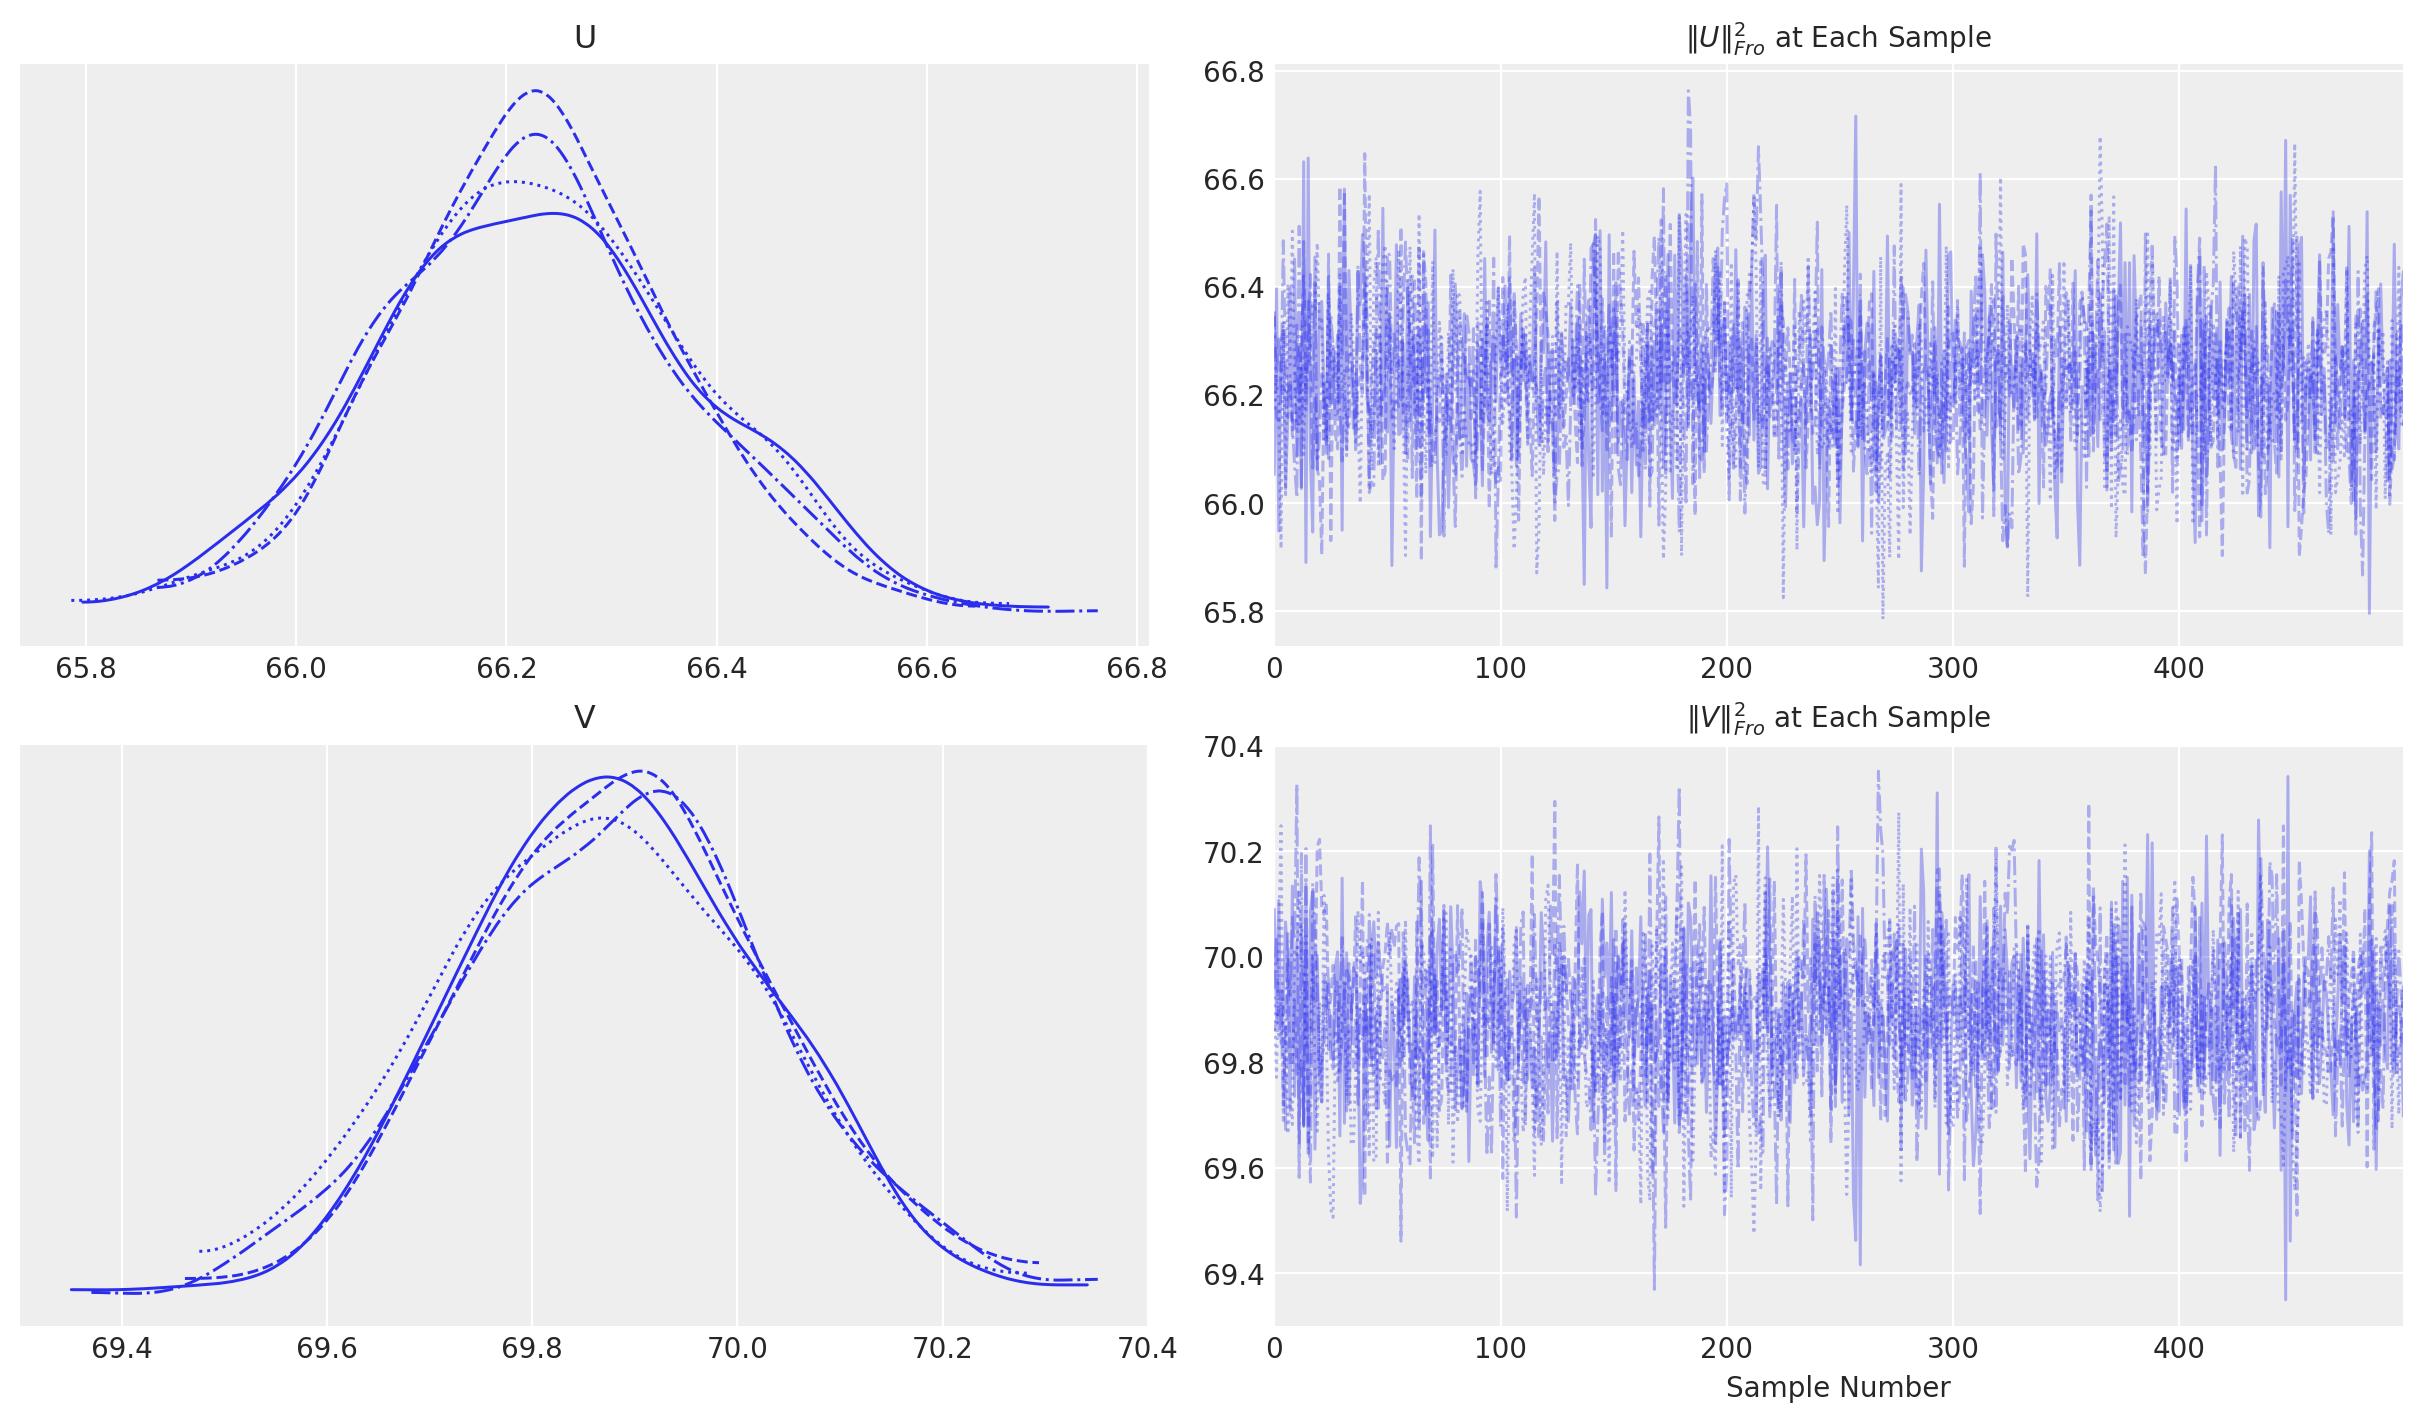

In [25]:
pmf.traceplot()

It appears we get convergence of $U$ and $V$ after about the default tuning. When testing for convergence, we also want to see convergence of the particular statistics we are looking for, since different characteristics of the posterior may converge at different rates. Let's also do a traceplot of the RMSE. We'll compute RMSE for both the train and the test set, even though the convergence is indicated by RMSE on the training set alone. In addition, let's compute a running RMSE on the train/test sets to see how aggregate performance improves or decreases as we continue to sample.

Because PMF is non-identifiable up to rotations and sign flips, chains can settle in different symmetric modes. We still run multiple chains to catch pathologies, but we focus on within-chain diagnostics like the Frobenius norms and RMSE rather than $\hat{R}$ for this model.

In [26]:
def _running_rmse(pmf_model, test_data, train_data, plot=True):
    """Calculate RMSE for each step of the trace to monitor convergence."""
    results = {"per-step-train": [], "running-train": [], "per-step-test": [], "running-test": []}
    R = np.zeros(test_data.shape)
    posterior = pmf_model.idata.posterior.stack(sample=("chain", "draw"))
    num_samples = posterior.sizes["sample"]
    for sample_idx in range(num_samples):
        U = posterior["U"].isel(sample=sample_idx).to_numpy()
        V = posterior["V"].isel(sample=sample_idx).to_numpy()
        sample_R = pmf_model.predict(U, V)
        R += sample_R
        running_R = R / (sample_idx + 1)
        results["per-step-train"].append(rmse(train_data, sample_R))
        results["running-train"].append(rmse(train_data, running_R))
        results["per-step-test"].append(rmse(test_data, sample_R))
        results["running-test"].append(rmse(test_data, running_R))

    results = pd.DataFrame(results)

    if plot:
        ax = results.plot(
            kind="line",
            grid=False,
            figsize=(15, 7),
            title="Per-step and Running RMSE From Posterior Predictive",
        )
        ax.set_xlabel("Sample")
        ax.set_ylabel("RMSE")

    # Return the final predictions, and the RMSE calculations
    return running_R, results


PMF.running_rmse = _running_rmse

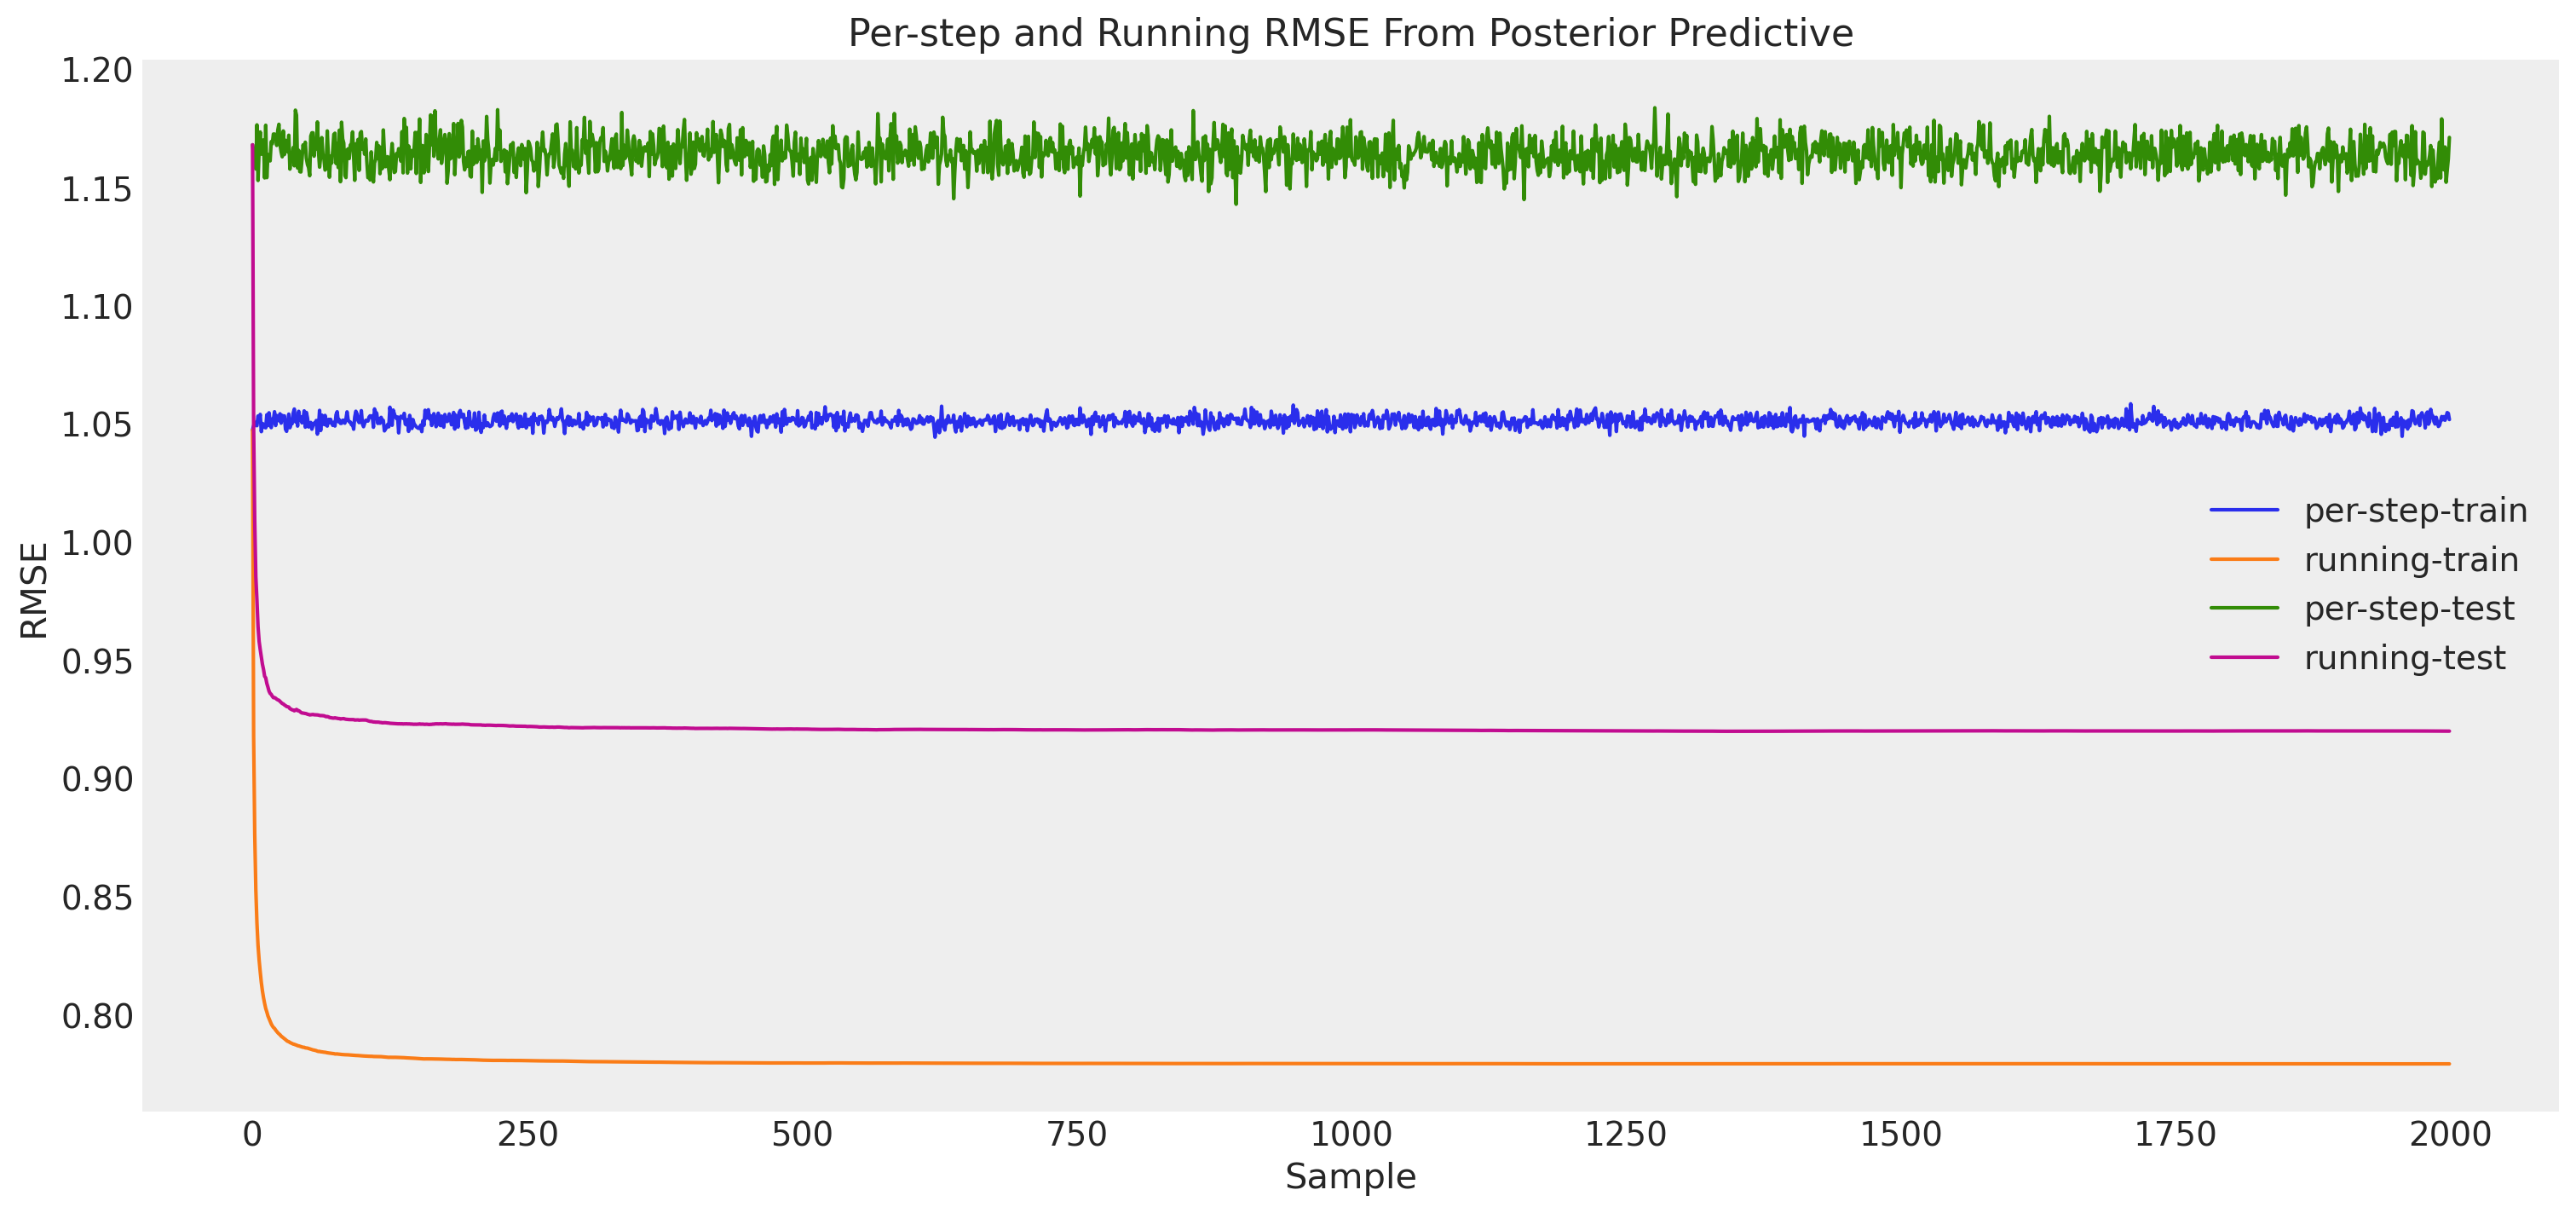

In [27]:
predicted, results = pmf.running_rmse(test, train)

In [28]:
# And our final RMSE?
final_test_rmse = results["running-test"].values[-1]
final_train_rmse = results["running-train"].values[-1]
print("Posterior predictive train RMSE: %.5f" % final_train_rmse)
print("Posterior predictive test RMSE:  %.5f" % final_test_rmse)
print("Train/test difference:           %.5f" % (final_test_rmse - final_train_rmse))
print("Improvement from MAP:            %.5f" % (pmf_map_rmse - final_test_rmse))
print("Improvement from Mean of Means:  %.5f" % (baselines["mom"] - final_test_rmse))

Posterior predictive train RMSE: 0.77943
Posterior predictive test RMSE:  0.92013
Train/test difference:           0.14069
Improvement from MAP:            0.22049
Improvement from Mean of Means:  0.10222


We have some interesting results here. As expected, our MCMC sampler provides lower error on the training set. However, it seems it does so at the cost of overfitting the data. This results in a decrease in test RMSE as compared to the MAP, even though it is still much better than our best baseline. So why might this be the case? Recall that we used point estimates for our precision parameters $\alpha_U$ and $\alpha_V$ and we chose a fixed precision $\alpha$. It is quite likely that by doing this, we constrained our posterior in a way that biased it towards the training data. In reality, the variance in the user ratings and the movie ratings is unlikely to be equal to the means of sample variances we used. Also, the most reasonable observation precision $\alpha$ is likely different as well.

### Summary of Results

Let's summarize our results.

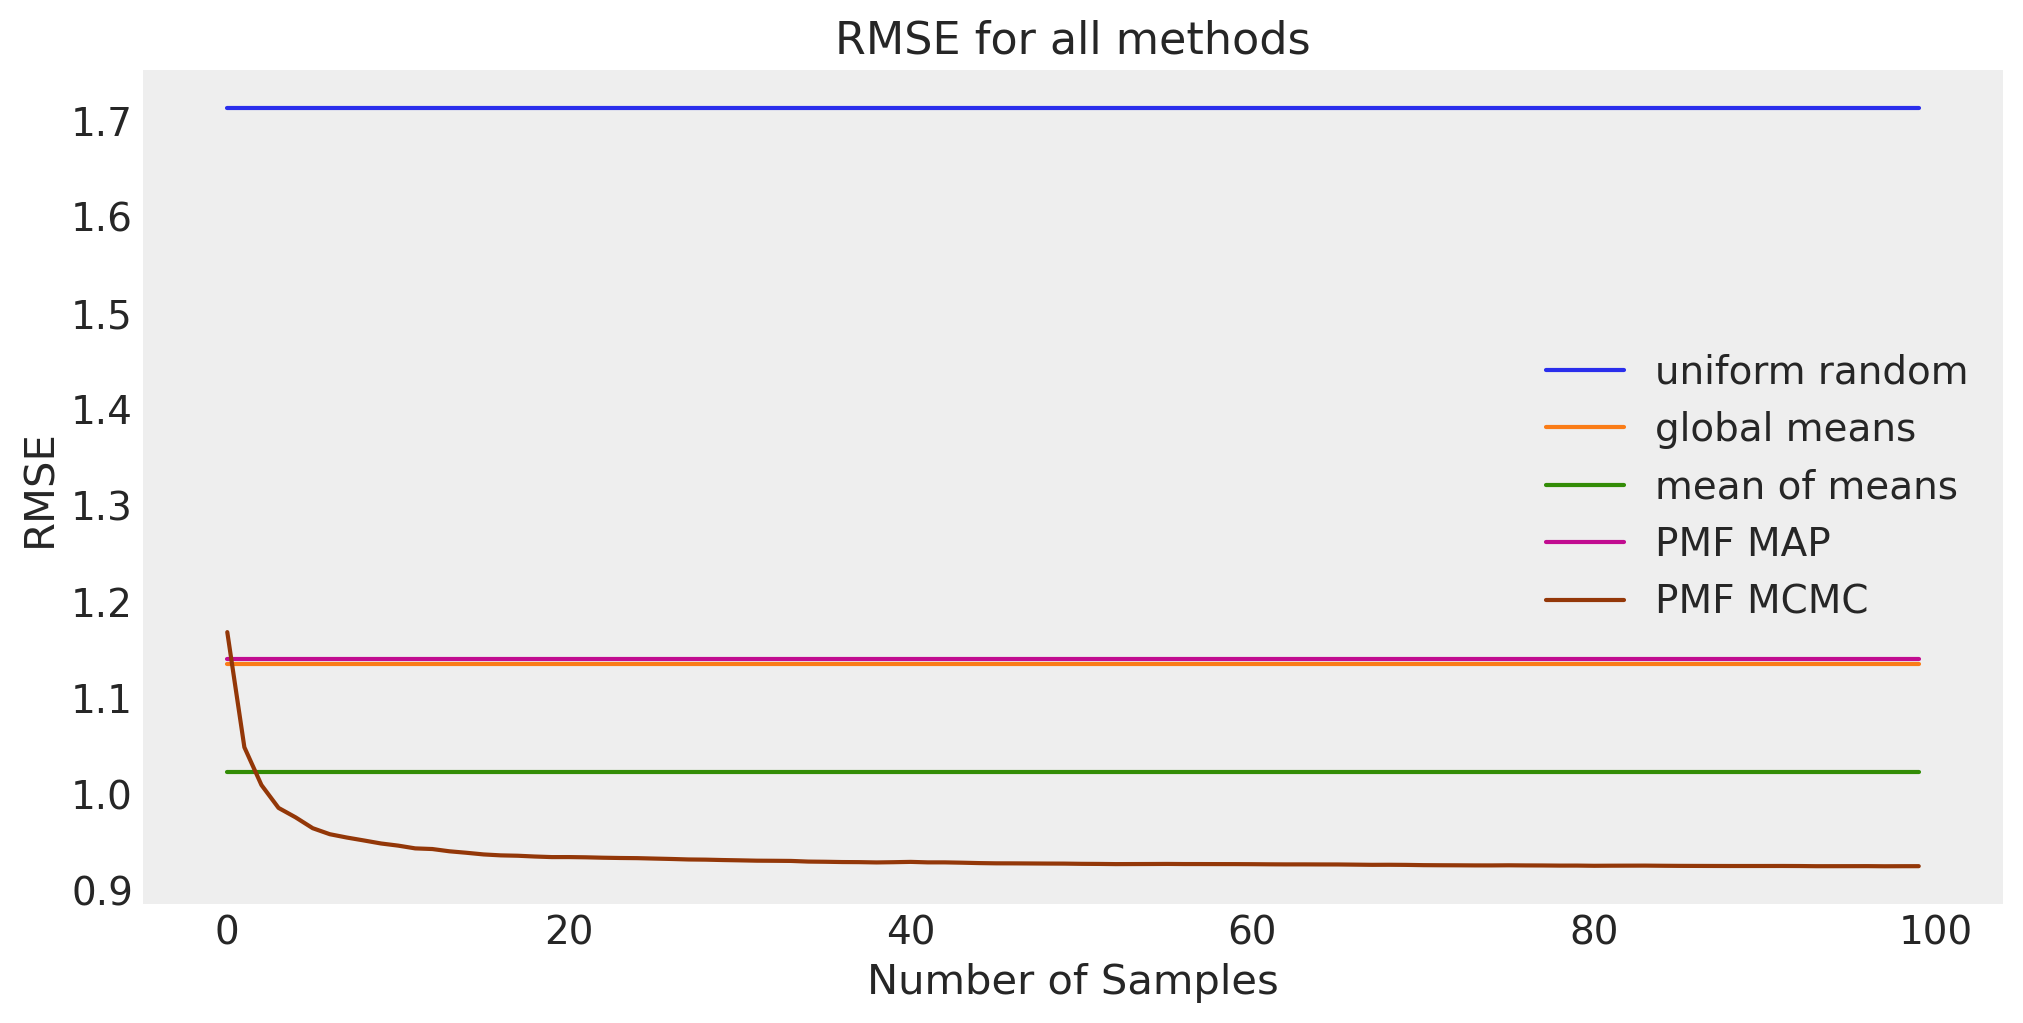

In [29]:
size = min(100, len(results))  # RMSE doesn't really change after 100th sample anyway.
all_results = pd.DataFrame(
    {
        "uniform random": np.repeat(baselines["ur"], size),
        "global means": np.repeat(baselines["gm"], size),
        "mean of means": np.repeat(baselines["mom"], size),
        "PMF MAP": np.repeat(pmf_map_rmse, size),
        "PMF MCMC": results["running-test"].iloc[:size].to_numpy(),
    }
)
fig, ax = plt.subplots(figsize=(10, 5))
all_results.plot(kind="line", grid=False, ax=ax, title="RMSE for all methods")
ax.set_xlabel("Number of Samples")
ax.set_ylabel("RMSE");

## Summary

We set out to predict user preferences for unseen movies. First we discussed the intuitive notion behind the user-user and item-item neighborhood approaches to collaborative filtering. Then we formalized our intuitions. With a firm understanding of our problem context, we moved on to exploring our subset of the MovieLens data. After discovering some general patterns, we defined three baseline methods: uniform random, global mean, and mean of means. With the goal of besting our baseline methods, we implemented the basic version of Probabilistic Matrix Factorization (PMF) using PyMC.

Our results demonstrate that the mean of means method is our best baseline on our prediction task. As expected, we are able to obtain a significant decrease in RMSE using the PMF MAP estimate obtained via L-BFGS-B optimization. We illustrated one way to monitor convergence of an MCMC sampler with a high-dimensionality sampling space using the Frobenius norms of the sampled variables. The traceplots using this method seem to indicate that our sampler converged to the posterior. Results using this posterior showed that attempting to improve the MAP estimation using MCMC sampling actually overfit the training data and increased test RMSE. This was likely caused by the constraining of the posterior via fixed precision parameters $\alpha$, $\alpha_U$, and $\alpha_V$.

As a followup to this analysis, it would be interesting to also implement the logistic and constrained versions of PMF. We expect both models to outperform the basic PMF model. We could also implement the fully Bayesian version of PMF (BPMF) {cite:p}`salakhutdinov2008bayesian`, which places hyperpriors on the model parameters to automatically learn ideal mean and precision parameters for $U$ and $V$. This would likely resolve the issue we faced in this analysis. We would expect BPMF to improve upon the MAP estimation produced here by learning more suitable hyperparameters and parameters. For a basic (but working!) implementation of BPMF in PyMC, see [this gist](https://gist.github.com/macks22/00a17b1d374dfc267a9a).

If you made it this far, then congratulations! You now have some idea of how to build a basic recommender system. These same ideas and methods can be used on many different recommendation tasks. Items can be movies, products, advertisements, courses, or even other people. Any time you can build yourself a user-item matrix with user preferences in the cells, you can use these types of collaborative filtering algorithms to predict the missing values. If you want to learn more about recommender systems, the first reference is a good place to start.

## Authors
- Authored by [Mack Sweeney](https://www.linkedin.com/in/macksweeney) with changes made to adapt the code and text for the MovieLens dataset by Colin Carroll and Rob Zinkov on June 3, 2022
- Updated by Christopher Krapu on January 17, 2026

## References

:::{bibliography}
:filter: docname in docnames

goldberg2001eigentaste
:::

## Watermark

In [30]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,aeppl,xarray

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Sun Jan 18 2026

Python implementation: CPython
Python version       : 3.14.2
IPython version      : 9.8.0

pytensor: 2.36.1
aeppl   : not installed
xarray  : 2025.12.0

xarray    : 2025.12.0
numpy     : 2.3.5
pandas    : 2.3.3
logging   : 0.5.1.2
pymc      : 5.27.0
arviz     : 0.23.0
matplotlib: 3.10.8

Watermark: 2.5.0



:::{include} ../page_footer.md
:::